In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
from textblob import TextBlob


def preprocessing(lines):
    words = lines.select(explode(split(lines.value, "t_end")).alias("word"))
    words = words.na.replace('', None)
    words = words.na.drop()
    words = words.withColumn('word', F.regexp_replace('word', r'http\S+', ''))
    words = words.withColumn('word', F.regexp_replace('word', '@\w+', ''))
    words = words.withColumn('word', F.regexp_replace('word', '#', ''))
    words = words.withColumn('word', F.regexp_replace('word', 'RT', ''))
    words = words.withColumn('word', F.regexp_replace('word', ':', ''))
    return words


def polarity_detection(text):
    return TextBlob(text).sentiment.polarity


def subjectivity_detection(text):
    return TextBlob(text).sentiment.subjectivity


def text_classification(words):
    # polarity detection
    polarity_detection_udf = udf(polarity_detection, StringType())
    words = words.withColumn("polarity", polarity_detection_udf("word"))
    # subjectivity detection
    subjectivity_detection_udf = udf(subjectivity_detection, StringType())
    words = words.withColumn("subjectivity", subjectivity_detection_udf("word"))
    return words



spark = SparkSession.builder.appName("TwitterSentimentAnalysis").getOrCreate()
lines = spark.readStream.format("socket").option("host", "127.0.0.1").option("port", 5555).load()
words = preprocessing(lines)
words = text_classification(words)

# words = words.repartition(1)
query = words.writeStream.queryName("all_tweets") \
    .outputMode("append").format("parquet") \
    .option("path", "./parc") \
    .option("checkpointLocation", "./check") \
    .trigger(processingTime='10 seconds').start()

query.awaitTermination()


KeyboardInterrupt: 

In [2]:
import glob
import pandas as pd

In [6]:
def read_data():
    dfs = []
    
    for file in glob.glob('parc/*.parquet'):
        dfs.append(pd.read_parquet(file))
        
    return pd.concat(dfs)

In [12]:
df = read_data()
df['polarity'] = df['polarity'].astype(float)
df['subjectivity'] = df['subjectivity'].astype(float)

In [13]:
df

,word,polarity,subjectivity
0,Chiranjeevi Charitable Trust.,0.600000,0.800000
1,Sikkim Govt should focus on upgrading existi...,0.000000,0.000000
2,"Liz Peek China's COVID lies, cover-up – here a...",-0.350000,0.900000
3,Prof Catherine Bennett says the impact of Vi...,0.136364,0.454545
4,"🇨🇭 Day of activism Monday, June 7",0.000000,0.000000
...,...,...,...
3,You can try this,0.000000,0.000000
4,This week we will be profiling the key recomme...,0.086111,0.697222
5,,0.000000,0.000000
6,🇺🇸 We should not take exams even if we have ...,-0.166667,0.066667


<AxesSubplot:ylabel='Frequency'>

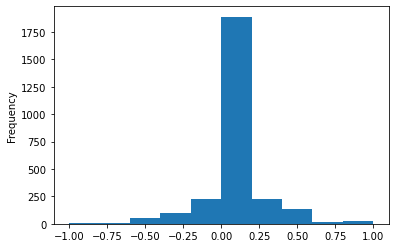

In [14]:
df['polarity'].plot(kind = 'hist')

<AxesSubplot:ylabel='Frequency'>

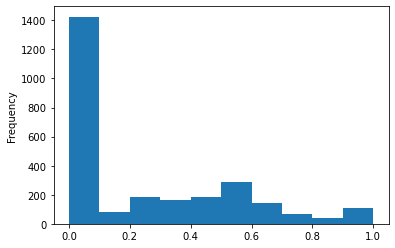

In [15]:
df['subjectivity'].plot(kind = 'hist')